# Security logs
____________________________

Logs are a really effective tool for making information about actions taken in a software easy to access and analyse. Which is why we made a logging feature for data owners to be able to track exactly what actions any users with access have taken or requested in relation to their datasets. 

In this tutorial, we are going to take a look at **how to access your security log dataframe** in BastionLab. We'll also cover **how to query your log dataframe** to retrieve the exact information you are interested in. 

But before we dive in, let's do some set-up!

## Pre-requisites
_______________________________

You'll need [Python](https://www.python.org/downloads/) and [Docker](https://www.docker.com/) installed on your machine to run this tutorial. 

> *You can refer to our [Installation section](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/installation/) to check the specific technical requirements needed by BastionLab's Client and Server, as well as other methods to install them if the following ones are not for you.*

We'll first install the packages of the [Polars](https://www.pola.rs/) library as well as [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/installation/)'s. Then we'll launch server with our Docker image.

In [55]:
!pip install bastionlab
!pip install polars
!docker pull mithrilsecuritysas/bastionlab:latest

## Setting up the keys
________________________________

In this tutorial, we are going to create three authenticated users: the `data_owner`, `data_scientist_1` and `data_scientist_2`. To do so, we'll use BastionLab's `Identity` module. It will help us to illustrate how the security log can track different users' actions.

>*To learn about the `Identity` module, you can check out our [authentication tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/authentication/).*

Note that the keys generated by the `Identity` class are placed in the current working directory.

In [56]:
from bastionlab import Identity

# Create `Identity` for the data owner.
data_owner = Identity.create("data_owner")

# Create `Identity` for data Scientists 1 and 2.
data_scientist_1 = Identity.create("data_scientist_1")
data_scientist_2 = Identity.create("data_scientist_2")

Now that we have setup our identities, we will have to start the server with the **public keys** of the data owner and the data scientists.

> *Note - This step will have to be done by the party setting up the server, commonly the **data owner**. They will have to get all the public keys of the interested parties.*

### Setting up the keys directory

We will now set up the `keys` directory that the server will use to verify users.

Let's follow the default schema:

```sh
keys/
├─ owners/
├─ users/
```

In [ ]:
!mkdir -p keys/owners keys/users

We can now copy the public keys of the data owner and data scientists into the revelant sub-directories.

In [58]:
!cp data_owner.pub keys/owners
!cp data_scientist_1.pub keys/users
!cp data_scientist_2.pub keys/users

### Starting BastionLab server with public keys

Finally, we can launch the server with our keys directory.

In [59]:
!docker run -it -p 50056:50056 -v $(pwd)/keys:/app/bin/keys mithrilsecuritysas/bastionlab:latest

## Data owner's side : uploading datasets
__________________________________________



We can finally start our tutorial by putting ourselves into the shoes of the data owner.

First, let's connect to the server!

We open an authenticated connection by providing the server's hostname and our identity:

In [60]:
from bastionlab import Connection

connection = Connection("localhost", identity=data_owner)
client = connection.client

Next, we will create there Polars dataframes and send them to the server.

In [61]:
import polars as pl

df1 = pl.DataFrame(
    {
        "Quarter": ["Q1", "Q2", "Q3", "Q4"],
        "Sales": [100000, 150000, 75000, 200000],
    }
)

df2 = pl.DataFrame({"Name": ["Laura", "Maya"], "Age": [29, 33]})

df3 = pl.DataFrame({"Element": ["Titanium"], "Melting Point (K)": [1945.0]})

rdf1 = client.polars.send_df(df1)
rdf2 = client.polars.send_df(df2)
rdf3 = client.polars.send_df(df3)

We can view a list of the dataframes that have been uploaded to the sever by using the `list_dfs()` method.

This is also the stage at which we'll grab hold of the identifiers for each uploaded dataframe - we'll use them later on.

In [62]:
RDF1 = rdf1.identifier
RDF2 = rdf2.identifier
RDF3 = rdf3.identifier

all_rdfs = client.polars.list_dfs()
all_rdfs

[FetchableLazyFrame(identifier=00000000-0000-0000-0000-000000000000),
 FetchableLazyFrame(identifier=9fa9f0c6-467a-4ec8-b8a1-40b5a3ae7813),
 FetchableLazyFrame(identifier=c363c951-26df-4fad-a02b-343647a62e58),
 FetchableLazyFrame(identifier=01d07847-40ee-4f65-b73c-27e886fcc4d6)]

## Accessing the security log
___________________________________

As you can see from the result of the previous code block, there are four dataframes available. Three of them represent our three uploaded dataframes and the final one, `00000000-0000-0000-0000-000000000000`, represents our security log. 

The identifier for this log will always be `00000000-0000-0000-0000-000000000000` but we can import the `LOG_DF` constant from `bastionlab.polars.remote_polars` instead of typing this out each time!

We can view the full log by using the `get_df()` method and then using `collect().fetch()` to extract the data.

In [63]:
from bastionlab.polars.remote_polars import LOG_DF

rd4 = client.polars.get_df(LOG_DF)
rd4.fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""9fa9f0c6-467a-...","""n/a""","""n/a"""
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""c363c951-26df-...","""n/a""","""n/a"""
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""01d07847-40ee-...","""n/a""","""n/a"""


We can see that the log recorded the **creation** of the three dataframes, `rdf1`, `rdf2` and `rdf3`, and the public key's hash of the user who took this action, the data owner in this case.

This is one of the three types of actions the log records. The other actions record when a user runs a **query** on the dataset and when a user **fetches** the dataset.

Let's add some of these actions to our log, by stepping into the shoes of our data scientists! We'll disconnect from the server as the data_owner.

In [64]:
connection.close()

## Data scientist's side
_______________________________

Now imagine we are Data scientist #1! 

We will connect to the server using the `Identity` we created earlier on. We'll have a look at the dataframes that have been uploaded by the data owner, using our security log feature. 

It's still nearly empty at this point, so let's fill it up so we can go back to being the data owner and have fun with the filtering options. 

In [65]:
connection = Connection("localhost", identity=data_scientist_1)
client = connection.client

rdf4 = client.polars.get_df(LOG_DF)
rdf4.filter(pl.col("Type") == "Send").collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""9fa9f0c6-467a-...","""n/a""","""n/a"""
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""c363c951-26df-...","""n/a""","""n/a"""
"""6984596979b0b2...","""2023-01-05 16:...","""Send""","""n/a""","""01d07847-40ee-...","""n/a""","""n/a"""


### Running Queries

We'll run a couple of queries as `data_scientist_1` and then as `data_scientist_2`.

Data scientist #1 is going to get a pie chart of the sales per quarter in `rdf1`.

> *You can learn more about our data visualization options in the [dedicated tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/visualization/).*

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 9fa9f0c6-467a-4ec8-b8a1-40b5a3ae7813.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


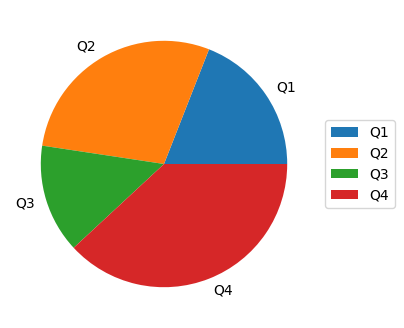

In [66]:
# get the data_owners rdf1 dataframe using its identifier
rdf1 = client.polars.get_df(RDF1)
rdf1.pieplot(parts="Sales", labels=["Q1", "Q2", "Q3", "Q4"])

connection.close()

Now Data scientist #2 will connect to the sever and view the number of elements in `rdf3`.

In [67]:
connection = Connection("localhost", identity=data_scientist_2)
client = connection.client

# get the data_owners rdf3 dataframe using its identifier
rdf3 = client.polars.get_df(RDF3)
fetch3 = rdf3.select(pl.col("Element")).collect().fetch()

Reason: Cannot fetch a result DataFrame that does not aggregate at least 10 rows of DataFrame 01d07847-40ee-4f65-b73c-27e886fcc4d6.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


In [68]:
connection.close()

### Querying the security log

The data scientists had their fun, let's now go back to being Data owner and imagine we want to know what actions have been taken specifically on `rdf1`.

We can filter the security log to specifically show the entries where the input `id` is `rdf1`'s `id`. We can see the fetches and queries ran by Data scientist #1 when they launched the pie function:

In [69]:
connection = Connection("localhost", identity=data_owner)
client = connection.client

# get security log
rdf4 = client.polars.get_df(LOG_DF)
rdf4.filter(pl.col("Inputs") == RDF1).collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""f529cc94f5f6cf...","""2023-01-05 16:...","""Run""","""9fa9f0c6-467a-...","""1d2485f1-f4e2-...","""[{""EntryPointP...","""n/a"""


By applying the same method, we can see the query `"Fetch"` actions. This time we will get all the `fetch()` actions applied on the 05/01/2022 which failed our privacy policy. Here we can see the queries respectively ran by Data scientist #1 and Data scientist #2 which required approval.

In [70]:
rdf4.filter(
    (pl.col("Type") == "Fetch")
    & pl.col("Time").str.starts_with("2023-01-05")
    & (pl.col("PolicyViolation") != "None")
).collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""f529cc94f5f6cf...","""2023-01-05 16:...","""Fetch""","""1d2485f1-f4e2-...","""n/a""","""n/a""","""Cannot fetch a..."
"""318f054ea97488...","""2023-01-05 16:...","""Fetch""","""28687ba4-6a07-...","""n/a""","""n/a""","""Cannot fetch a..."


Finally, we can get the log as a `.csv` file by using Polars `write_csv` method:

In [71]:
rdf4.collect().fetch().write_csv("log.csv")

That brings us to the end of our introduction to security logging in BastionLab. We can now close our connection to the server:

In [72]:
connection.close()